## Canine GWAS Variant QC

In [1]:
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os.path as osp
# from bokeh.io import show, output_notebook
# from bokeh.layouts import gridplot
# output_notebook()
%run ../../nb.py
%run files.py
%run common.py
gab.register_timeop_magic(get_ipython(), 'hail')
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://d42c6af5a4e5:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200211-0424-0.2.30-2ae07d872f43.log


### Reference Data QC

The initial steps in the pipeline will involved loading the NHGRI Dog Genome data and running some basic QC steps, including:
    
- Run call rate filtering
- Group the samples by the 3 most common breeds
- Run MAF and HWE filtering on all variants for each breed separately, and identify variants that pass all filters in all breeds
- Filter the original reference data to the passing variant set
- Run LD pruning
- Remove C/G and A/T SNPs

In [2]:
hl.ReferenceGenome(**load_reference_genome(REF_GENOME_FILE))

ReferenceGenome(name=canine, contigs=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '41'], lengths={'1': 122670980, '2': 85416217, '3': 91858198, '4': 88267880, '5': 88908300, '6': 77552613, '7': 80858461, '8': 74057381, '9': 61043804, '10': 69316974, '11': 74388336, '12': 72480470, '13': 63232306, '14': 60959782, '15': 64187680, '16': 59511764, '17': 64281982, '18': 55763074, '19': 53735656, '20': 58114749, '21': 50855586, '22': 61382644, '23': 52291577, '24': 47651928, '25': 51628093, '26': 38939728, '27': 45753342, '28': 41164216, '29': 41841565, '30': 40196606, '31': 39786599, '32': 38745890, '33': 31361794, '34': 42089769, '35': 26506199, '36': 30798114, '37': 30897806, '38': 23903967, '39': 123833839, '41': 6608343}, x_contigs=['39'], y_contigs=[], mt_contigs=['41'], par=[])

In [4]:
mt = hl.import_plink(
    *plink_files(ORGANISM_CANINE_REF_DIR, PLINK_FILE_REF),
    skip_invalid_loci=False, 
    reference_genome='canine'
)
mt.count()

2020-02-11 04:24:46 Hail: INFO: Found 1355 samples in fam file.
2020-02-11 04:24:46 Hail: INFO: Found 150131 variants in bim file.
2020-02-11 04:24:48 Hail: INFO: Coerced sorted dataset


(150131, 1355)

#### Call Rate QC

2020-02-11 04:24:54 Hail: INFO: Coerced sorted dataset
2020-02-11 04:25:02 Hail: INFO: Coerced sorted dataset
2020-02-11 04:25:03 Hail: INFO: Coerced sorted dataset
2020-02-11 04:25:03 Hail: INFO: Coerced sorted dataset


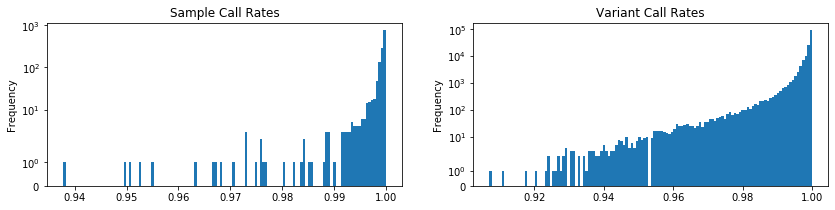

In [5]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((14, 3))
axs[0].set_title('Sample Call Rates')
axs[0].set_yscale('symlog')
axs[1].set_title('Variant Call Rates')
axs[1].set_yscale('symlog')
pd.Series(hl.sample_qc(mt).sample_qc.call_rate.collect()).plot(kind='hist', bins=128, ax=axs[0])
pd.Series(hl.variant_qc(mt).variant_qc.call_rate.collect()).plot(kind='hist', bins=128, ax=axs[1])

In [6]:
def call_rate_qc(mt):
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= .96)
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate >= .96)
    return mt
mt_qc = call_rate_qc(mt)
mt_qc.count()

2020-02-11 04:25:22 Hail: INFO: Coerced sorted dataset
2020-02-11 04:25:29 Hail: INFO: Coerced sorted dataset
2020-02-11 04:25:38 Hail: INFO: Coerced sorted dataset
2020-02-11 04:25:38 Hail: INFO: Coerced sorted dataset


(149845, 1350)

In [ ]:
mt_qc.write()

### Group by Common Breed